
Model Evaluation Results:
                  Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.480263   0.432836  0.414286  0.423358
1        Random Forest  0.532895   0.490566  0.371429  0.422764
2                  SVM  0.526316   0.482143  0.385714  0.428571

Top 3 Important Features Influencing Mental Stress:
                              Feature  Importance
3                Study Hours Per Week    0.120460
6  Physical Exercise (Hours per week)    0.085794
4  Social Media Usage (Hours per day)    0.075879


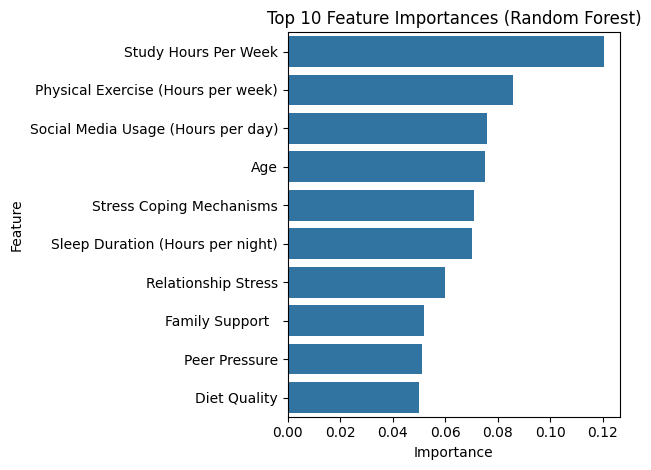


Explained variance ratio by PCA components: [0.06839345 0.06683797]

T-test result:
  t-statistic = 3.449, p-value = 0.001
Conclusion: Significant difference from the hypothesized mean of 5.

Z-test result:
  z-statistic = 1.176, p-value = 0.240
Conclusion: No significant difference in study hours between groups.

Chi-square test result:
  chi2 = 8.910, p-value = 0.259
Conclusion: No significant relationship between gender and counseling attendance.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA

from scipy.stats import ttest_1samp, chi2_contingency
from statsmodels.stats.weightstats import ztest


df = pd.read_csv("/content/Student_Mental_Stress_and_Coping_Mechanisms.csv")
df.drop(columns=["Student ID"], inplace=True)


label_encoders = {}
for col in df.select_dtypes(include="object").columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


imputer = SimpleImputer(strategy="median")
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)


scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed), columns=df.columns)



X = df_scaled.drop(columns=["Mental Stress Level"])
y = df_scaled["Mental Stress Level"]
y_binary = (df_imputed["Mental Stress Level"] > df_imputed["Mental Stress Level"].median()).astype(int)

X_train, X_test, y_train_binary, y_test_binary = train_test_split(X, y_binary, test_size=0.2, random_state=42)
_, _, y_train_cont, y_test_cont = train_test_split(X, y, test_size=0.2, random_state=42)



models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

results = []
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train_binary)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test_binary, y_pred),
        "Precision": precision_score(y_test_binary, y_pred),
        "Recall": recall_score(y_test_binary, y_pred),
        "F1 Score": f1_score(y_test_binary, y_pred)
    })

results_df = pd.DataFrame(results)
print("\nModel Evaluation Results:\n", results_df)


rf_model = models["Random Forest"]
importances = rf_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

print("\nTop 3 Important Features Influencing Mental Stress:")
print(importance_df.head(3))


sns.barplot(x="Importance", y="Feature", data=importance_df.head(10))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print("\nExplained variance ratio by PCA components:", pca.explained_variance_ratio_)


t_stat, t_p_value = ttest_1samp(df_imputed["Mental Stress Level"], popmean=5)
print(f"\nT-test result:\n  t-statistic = {t_stat:.3f}, p-value = {t_p_value:.3f}")
if t_p_value < 0.05:
    print("Conclusion: Significant difference from the hypothesized mean of 5.")
else:
    print("Conclusion: No significant difference from the hypothesized mean of 5.")

group1 = df_imputed[df_imputed["Counseling Attendance"] == 1]["Study Hours Per Week"]
group2 = df_imputed[df_imputed["Counseling Attendance"] == 0]["Study Hours Per Week"]
z_stat, z_p_value = ztest(group1, group2)
print(f"\nZ-test result:\n  z-statistic = {z_stat:.3f}, p-value = {z_p_value:.3f}")
if z_p_value < 0.05:
    print("Conclusion: Significant difference in study hours between groups.")
else:
    print("Conclusion: No significant difference in study hours between groups.")


chi2_table = pd.crosstab(df_imputed["Gender"], df_imputed["Counseling Attendance"])
chi2, chi_p, _, _ = chi2_contingency(chi2_table)
print(f"\nChi-square test result:\n  chi2 = {chi2:.3f}, p-value = {chi_p:.3f}")
if chi_p < 0.05:
    print("Conclusion: Gender is significantly associated with counseling attendance.")
else:
    print("Conclusion: No significant relationship between gender and counseling attendance.")
